## **Aplicação de Decision Tree Regression**
Neste notebook será aplicado o modelo Decision Tree Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from src.evaluation import Evaluation
from src.plots import plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


%load_ext autoreload
%autoreload 2

EVAL_PATH = '../data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("../data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("../data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [3]:
import json

with open("../data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

## **Decision Tree Regression**

In [4]:
from src.features import add_trend


def dt_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query(
        "unique_id == @train.unique_id[0]").reset_index(drop=True)
    train, fcst_df = add_trend(train, fcst_df)
    features = selected_features[train.unique_id[0]]

    m = DecisionTreeRegressor()
    m.fit(X=train[features], y=train.y)

    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [5]:
# aplicando modelo para cada série
dt_fcst = train_df.groupby("unique_id") \
    .apply(dt_regressor) \
    .reset_index(drop=True)

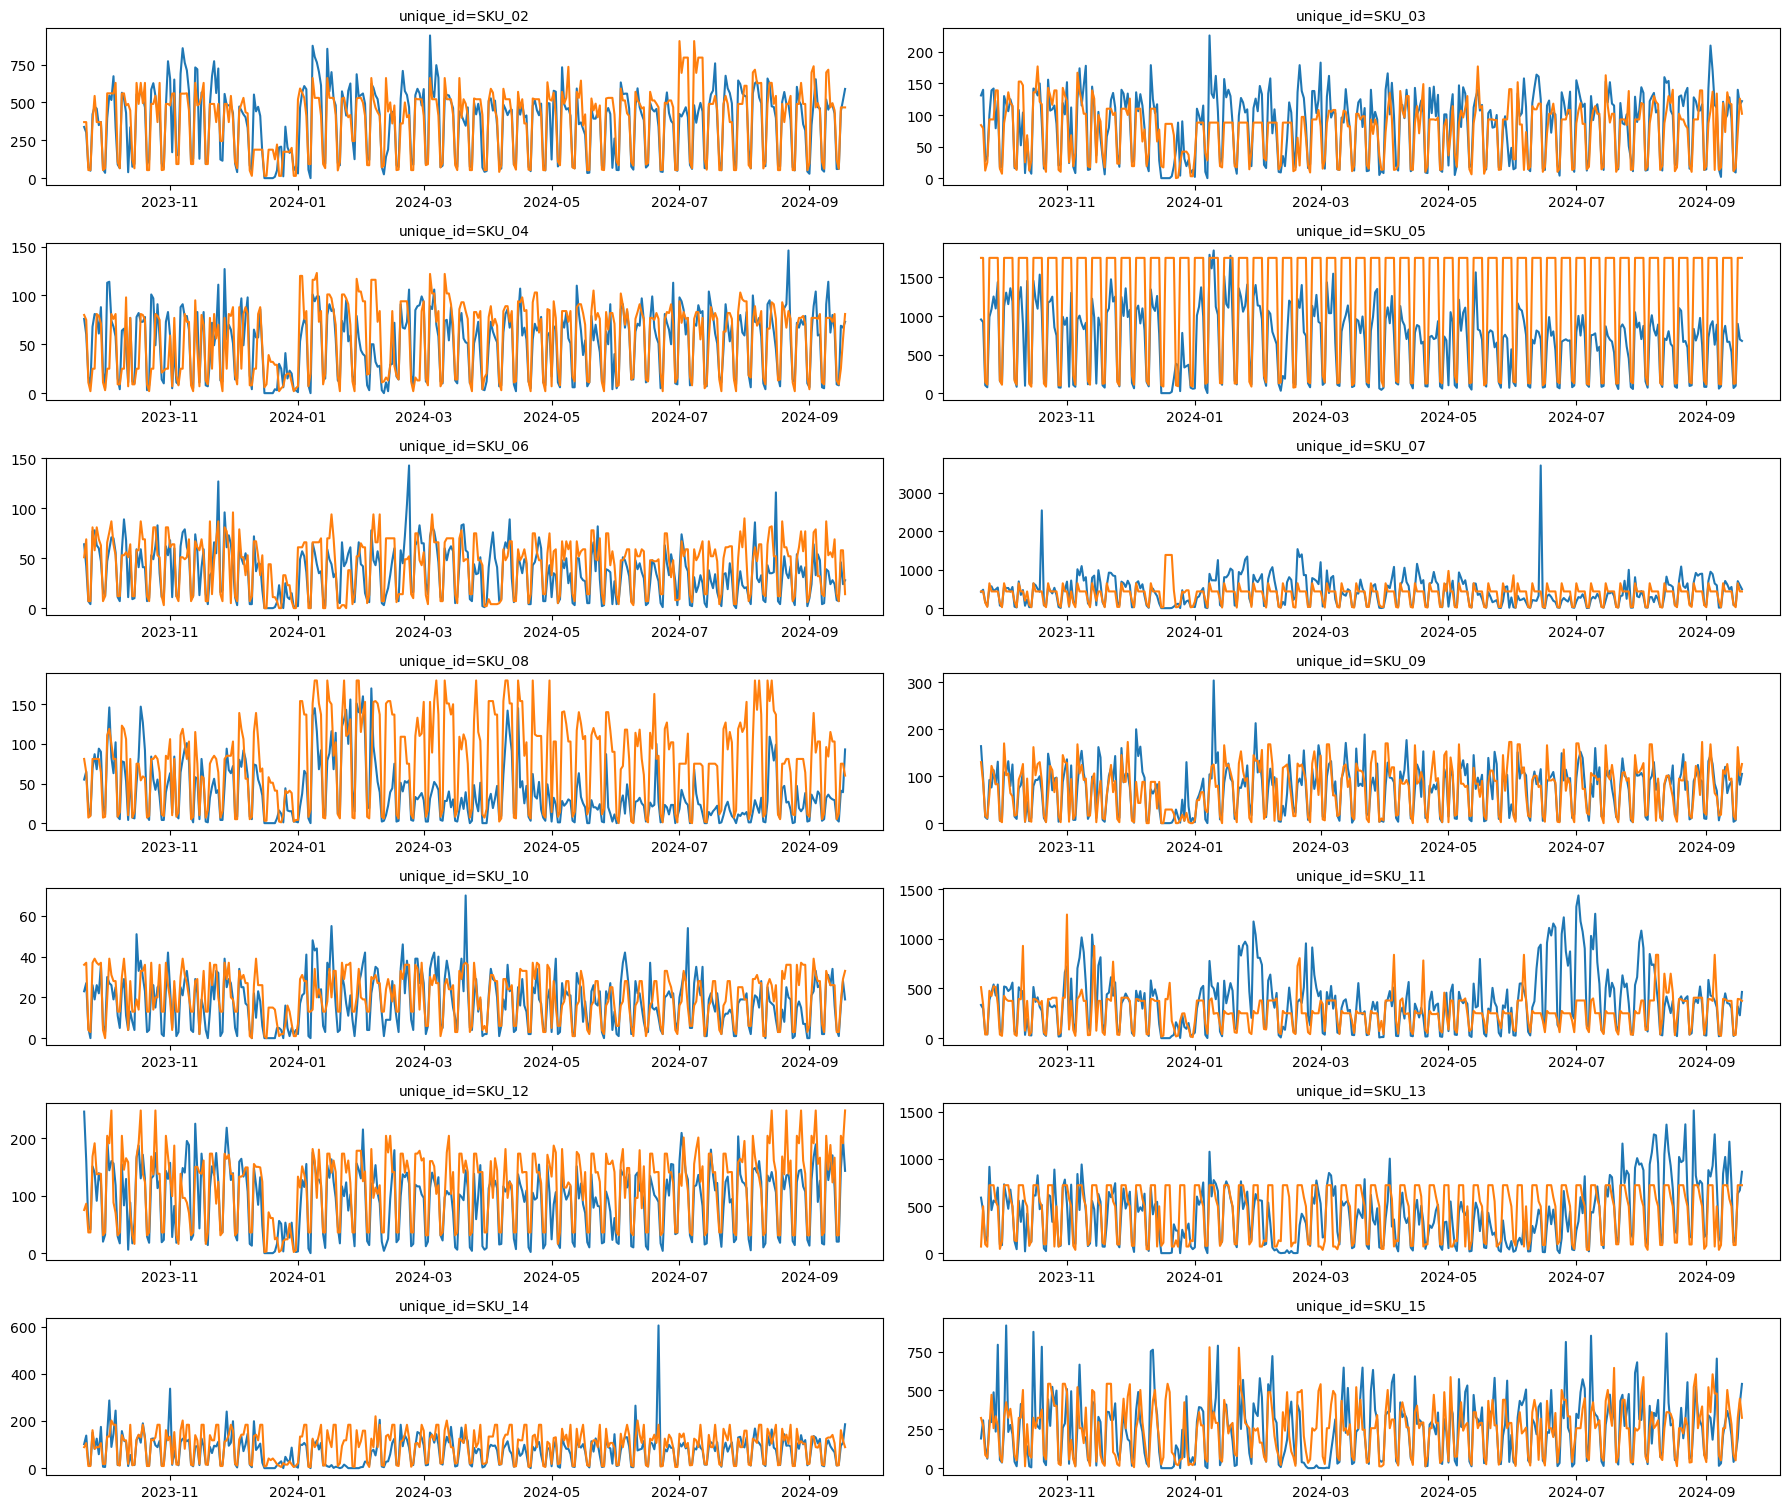

In [6]:
fig = plot_time_series(df=dt_fcst, data_cols=['y', 'y_pred'], figsize=(18, 16))

In [7]:
rf_eval = Evaluation(dt_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Decision Tree')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_02,95.21,19222.75,138.65,0.62
SKU_03,25.56,1276.95,35.73,0.55
SKU_04,18.38,682.33,26.12,0.39
SKU_05,626.96,600958.40,775.22,-1.92
SKU_06,17.98,567.46,23.82,0.11
SKU_07,212.57,132078.53,363.43,0.14
SKU_08,46.37,3778.11,61.47,-1.78
SKU_09,26.94,1522.85,39.02,0.42
SKU_10,8.05,112.91,10.63,0.30
SKU_11,178.94,79366.30,281.72,0.11


In [8]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('r2','unique_id','model')[order]
metrics.T

unique_id,SKU_02,SKU_03,SKU_04,SKU_05,SKU_06,SKU_07,SKU_08,SKU_09,SKU_10,SKU_11,SKU_12,SKU_13,SKU_14,SKU_15
model,,,,,,,,,,,,,,
Naive Sazonal,0.09,-0.04,0.21,-0.45,0.08,-0.02,-1.22,-0.05,-0.80,-0.08,-0.25,-0.15,-0.05,-0.96
SARIMA,0.64,0.63,0.50,0.46,0.27,-0.79,-0.92,0.00,0.28,0.39,0.51,-0.01,0.21,-0.02
ETS,0.65,0.63,0.58,0.35,0.38,0.16,-0.93,0.53,-0.13,0.26,0.55,0.34,0.30,0.43
Decision Tree,0.62,0.55,0.39,-1.92,0.11,0.14,-1.78,0.42,0.30,0.11,0.31,0.18,0.08,0.28
